## Teoría de Q-learning Aplicada al Entorno de MountainCar

Q-learning es un algoritmo de aprendizaje por refuerzo que se utiliza para encontrar la política óptima en un problema de decisión secuencial. En el contexto de este trabajo, se aplica al entorno de MountainCar, un problema clásico de control en el que un coche debe aprender a subir una colina empinada.

### Conceptos Clave de Q-learning:

1. **Estados y Acciones**:
   - **Estado**: Representa la situación actual del entorno. En MountainCar, el estado puede incluir la posición y la velocidad del coche.
   - **Acción**: Una decisión que el agente puede tomar. En este entorno, las acciones pueden ser acelerar hacia la izquierda, hacia la derecha o no acelerar.

2. **Función de Valor Q**:
   - La función de valor Q, \( Q(s, a) \), estima la utilidad de tomar una acción \( a \) en un estado \( s \). Esta función se actualiza iterativamente para reflejar el valor esperado de las acciones.

3. **Actualización de Q-learning**:
   - La actualización de la función Q se realiza mediante la ecuación de Bellman:
   \[
   Q(s, a) \leftarrow Q(s, a) + \alpha \left[ r + \gamma \max_{a'} Q(s', a') - Q(s, a) \right]
   \]
   - Donde:
     - \( \alpha \) es la tasa de aprendizaje.
     - \( r \) es la recompensa recibida después de tomar la acción \( a \).
     - \( \gamma \) es el factor de descuento que determina la importancia de las recompensas futuras.
     - \( s' \) es el nuevo estado después de tomar la acción \( a \).

4. **Política**:
   - La política es la estrategia que sigue el agente para elegir acciones. En Q-learning, la política se deriva de la función Q, eligiendo la acción con el valor Q más alto en cada estado.

5. **Exploración vs. Explotación**:
   - El agente debe equilibrar la exploración de nuevas acciones con la explotación de acciones conocidas que proporcionan altas recompensas. Esto se maneja comúnmente con una estrategia \(\epsilon\)-greedy, donde \(\epsilon\) es la probabilidad de elegir una acción aleatoria.

### Aplicación en MountainCar:

En el entorno de MountainCar, el objetivo del agente es aprender a balancear el coche para que gane suficiente impulso y pueda subir la colina. El agente utiliza Q-learning para aprender la mejor secuencia de acciones que maximicen la recompensa, que generalmente se define como alcanzar la cima de la colina en el menor número de pasos posible.

El proceso de entrenamiento implica iterar sobre episodios donde el agente explora el entorno, actualiza la función Q y ajusta su política para mejorar su rendimiento en el tiempo. Al final del entrenamiento, el agente debería ser capaz de resolver el problema de manera eficiente, utilizando la política derivada de la función Q aprendida.

In [26]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
import pickle
from tqdm import tqdm
import pandas as pd
import datetime
import os

### Definición de la Función `run`
Esta celda define la función `run`, que ejecuta el algoritmo de Q-learning en el entorno "MountainCar-v0". La función tiene los siguientes parámetros:
- `episodes`: Número de episodios a ejecutar.
- `is_training`: Indica si la ejecución es para entrenamiento (`True`) o prueba (`False`).
- `render`: Si es `True`, se visualiza el entorno durante la ejecución.

Dentro de la función:
- Se inicializa el entorno de MountainCar.
- Se discretiza el espacio de observación en segmentos para la posición y la velocidad.
- Se implementa la lógica de entrenamiento o prueba del agente, actualizando la tabla Q durante el entrenamiento.
- Se registran métricas como recompensas y valores de epsilon.
- Se guardan la tabla Q y las métricas en archivos al finalizar el entrenamiento.

In [27]:
def run(episodes, is_training=True, render=False):
    env = gym.make('MountainCar-v0', render_mode='human' if render else None)

    # Divide position and velocity into segments
    pos_space = np.linspace(env.observation_space.low[0], env.observation_space.high[0], 20)    # Between -1.2 and 0.6
    vel_space = np.linspace(env.observation_space.low[1], env.observation_space.high[1], 20)    # Between -0.07 and 0.07

    if(is_training):
        q = np.zeros((len(pos_space), len(vel_space), env.action_space.n)) # init a 20x20x3 array
    else:
        f = open('mountain_car.pkl', 'rb')
        q = pickle.load(f)
        f.close()

    learning_rate_a = 0.9 # alpha or learning rate
    discount_factor_g = 0.9 # gamma or discount factor.

    epsilon = 1         # 1 = 100% random actions
    epsilon_decay_rate = 2/episodes # epsilon decay rate
    rng = np.random.default_rng()   # random number generator

    # Create progress bar
    pbar = tqdm(range(episodes))
    
    # Variables for progress bar updates and metrics
    best_reward = float('-inf')
    avg_reward = 0
    metrics_data = []
    
    for i in pbar:
        state = env.reset()[0]      # Starting position, starting velocity always 0
        state_p = np.digitize(state[0], pos_space)
        state_v = np.digitize(state[1], vel_space)

        terminated = False          # True when reached goal
        rewards = 0

        while(not terminated and rewards>-1000):
            if is_training and rng.random() < epsilon:
                # Choose random action (0=drive left, 1=stay neutral, 2=drive right)
                action = env.action_space.sample()
            else:
                action = np.argmax(q[state_p, state_v, :])

            new_state,reward,terminated,_,_ = env.step(action)
            new_state_p = np.digitize(new_state[0], pos_space)
            new_state_v = np.digitize(new_state[1], vel_space)

            if is_training:
                q[state_p, state_v, action] = q[state_p, state_v, action] + learning_rate_a * (
                    reward + discount_factor_g*np.max(q[new_state_p, new_state_v,:]) - q[state_p, state_v, action]
                )

            state = new_state
            state_p = new_state_p
            state_v = new_state_v

            rewards += reward

        epsilon = max(epsilon - epsilon_decay_rate, 0)
        
        # Update best reward
        if rewards > best_reward:
            best_reward = rewards
            
        # Calculate average reward over last 100 episodes
        if i >= 100:
            avg_reward = np.mean([d['Reward'] for d in metrics_data[-100:]])
        
        # Store metrics for every episode
        metrics_data.append({
            'Episode': i + 1,
            'Reward': rewards,
            'Average_Reward': avg_reward,
            'Best_Reward': best_reward,
            'Epsilon': epsilon,
            'Learning_Rate': learning_rate_a,
            'Discount_Factor': discount_factor_g
        })
        
        # Update progress bar description
        pbar.set_description(f"Episode {i+1}/{episodes} | Best: {best_reward:.2f} | Avg: {avg_reward:.2f} | Epsilon: {epsilon:.3f}")

    env.close()

    # Save Q table to file
    if is_training:
        f = open('mountain_car.pkl','wb')
        pickle.dump(q, f)
        f.close()
        
        # Create DataFrame from metrics
        metrics_df = pd.DataFrame(metrics_data)
        
        # Save metrics to CSV
        metrics_df.to_csv('mountain_car_metrics.csv', index=False)
        
        return metrics_df

In [ ]:
def plot_results(metrics_df):
    # Create a figure with two subplots
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))
    
    # Plot 1: Rewards per Episode
    ax1.plot(metrics_df['Episode'], metrics_df['Reward'])
    ax1.set_title('Rewards per Episode')
    ax1.set_xlabel('Episode')
    ax1.set_ylabel('Reward')
    ax1.grid(True)
    
    # Plot 2: Training Metrics
    ax2.plot(metrics_df['Episode'], metrics_df['Average_Reward'], 'b-', label='Average Reward')
    ax2.plot(metrics_df['Episode'], metrics_df['Best_Reward'], 'g-', label='Best Reward')
    ax2.set_title('Training Metrics')
    ax2.set_xlabel('Episode')
    ax2.set_ylabel('Reward')
    ax2.legend()
    ax2.grid(True)

    plt.show()
    
    plt.tight_layout()
    plt.savefig('mountain_car_training_results.png')
    plt.close()

In [28]:
# Train the agent for 5000 episodes
metrics_df = run(5000, is_training=True, render=False)

Episode 5000/5000 | Best: -134.00 | Avg: -143.26 | Epsilon: 0.000: 100%|██████████| 5000/5000 [03:08<00:00, 26.54it/s] 


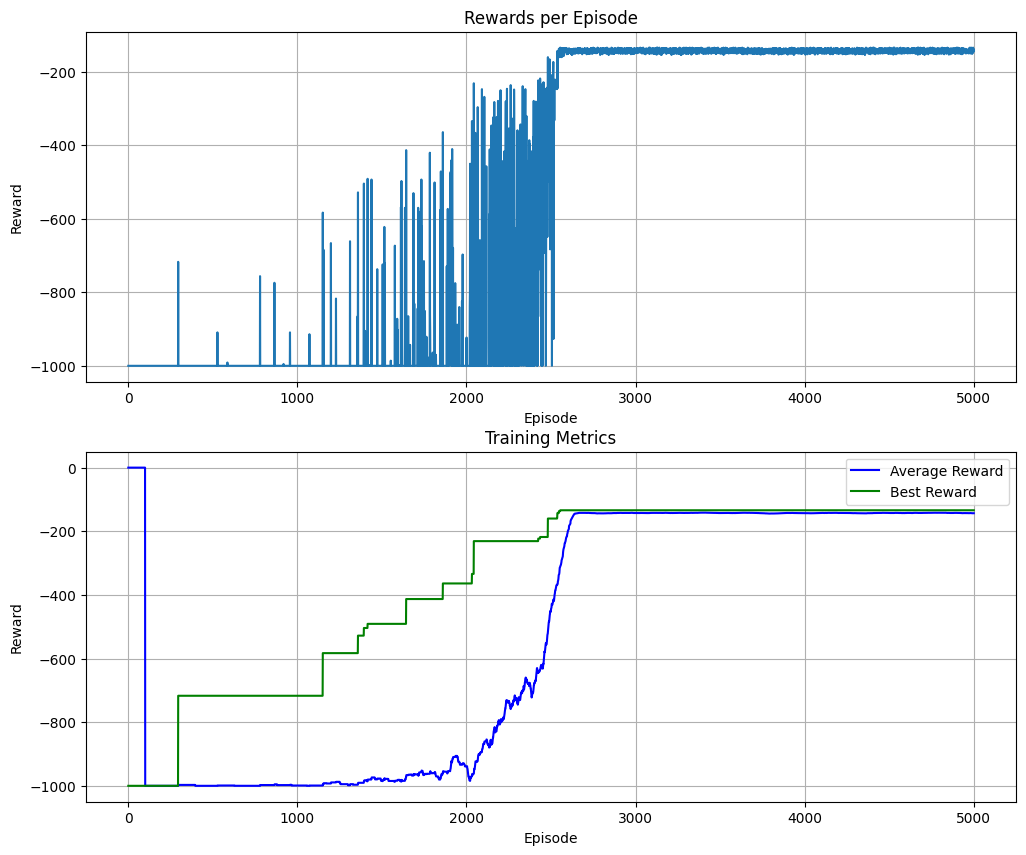

In [29]:
# Plot the results
plot_results(metrics_df)

In [30]:
# Display final metrics
print("\nFinal Training Metrics:")
print(metrics_df.tail())


Final Training Metrics:
      Episode  Reward  Average_Reward  Best_Reward  Epsilon  Learning_Rate  \
4995     4996  -134.0         -143.33       -134.0      0.0            0.9   
4996     4997  -145.0         -143.17       -134.0      0.0            0.9   
4997     4998  -137.0         -143.27       -134.0      0.0            0.9   
4998     4999  -137.0         -143.30       -134.0      0.0            0.9   
4999     5000  -144.0         -143.26       -134.0      0.0            0.9   

      Discount_Factor  
4995              0.9  
4996              0.9  
4997              0.9  
4998              0.9  
4999              0.9  


In [31]:
# Test the trained agent for 10 episodes with visualization
run(3, is_training=False, render=True)

Episode 3/3 | Best: -134.00 | Avg: 0.00 | Epsilon: 0.000: 100%|██████████| 3/3 [00:14<00:00,  4.97s/it]


In [34]:
# Create a directory for results if it doesn't exist
results_dir = 'training_results'
if not os.path.exists(results_dir):
    os.makedirs(results_dir)

# Get current timestamp for unique filenames
timestamp = datetime.datetime.now().strftime('%Y%m%d_%H%M%S')

# Save the DataFrame
df_path = os.path.join(results_dir, f'mountain_car_metrics_{timestamp}.csv')
metrics_df.to_csv(df_path, index=False)
print(f"Metrics DataFrame saved to: {df_path}")

# Save training parameters
params = {
    'episodes': 5000,
    'learning_rate': 0.9,
    'discount_factor': 0.9,
    'epsilon_decay_rate': 2/5000,
    'state_space_bins': 20,
    'timestamp': timestamp
}

params_path = os.path.join(results_dir, f'training_params_{timestamp}.txt')
with open(params_path, 'w') as f:
    for key, value in params.items():
        f.write(f"{key}: {value}\n")
print(f"Training parameters saved to: {params_path}")

# Display summary of saved files
print("\nSaved Files Summary:")
print(f"2. Metrics DataFrame: {df_path}")
print(f"3. Training Parameters: {params_path}")

# Display final metrics summary
print("\nFinal Training Metrics Summary:")
print(f"Best Reward: {metrics_df['Best_Reward'].max():.2f}")
print(f"Final Average Reward: {metrics_df['Average_Reward'].iloc[-1]:.2f}")
print(f"Final Epsilon: {metrics_df['Epsilon'].iloc[-1]:.10f}")
print(f"Total Episodes: {len(metrics_df)}")

Metrics DataFrame saved to: training_results\mountain_car_metrics_20250321_222356.csv
Training parameters saved to: training_results\training_params_20250321_222356.txt

Saved Files Summary:
2. Metrics DataFrame: training_results\mountain_car_metrics_20250321_222356.csv
3. Training Parameters: training_results\training_params_20250321_222356.txt

Final Training Metrics Summary:
Best Reward: -134.00
Final Average Reward: -143.26
Final Epsilon: 0.0000000000
Total Episodes: 5000
